<a href="https://colab.research.google.com/github/james811223/Recommender-system/blob/master/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Digital_Music.json.gz
!gunzip meta_Digital_Music.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz
!gunzip Digital_Music_5.json.gz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://apache.osuosl.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar -xvf spark-3.0.0-bin-hadoop3.2.tgz
!pip install -q findspark
import os, findspark, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"
findspark.init()
from pyspark.sql import SparkSession, functions as f, types
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
%matplotlib inline

In [3]:
sns.set_style('darkgrid',{'figure.facecolor': 'lightblue'})

# Load and wrangle data

In [4]:
review = spark.read.json('Digital_Music_5.json')
meta_data = spark.read.json('meta_Digital_Music.json')

In [5]:
def show_missing_count(df):
    '''Show missing data count and %'''
    exp = [f'cast(round(mean(int(isnull({c}))) * 100,2) as string) as {c}' for c in df.columns]
    t2 = df.selectExpr(*exp)
    exp = [f.concat(f.col(c),f.lit('% missing')).alias(c) for c in t2.columns]
    t2 = t2.select(*exp)
    exp = [f'cast(sum(int(isnull({c}))) as string) as {c}' for c in df.columns]
    t1 = df.selectExpr(*exp)
    t1.union(t2).show()

In [6]:
show_missing_count(review)

+------------+--------------+------------+-------------+------------+------------+------------+-------------+-------------+--------------+------------+--------------+
|        asin|         image|     overall|   reviewText|  reviewTime|  reviewerID|reviewerName|        style|      summary|unixReviewTime|    verified|          vote|
+------------+--------------+------------+-------------+------------+------------+------------+-------------+-------------+--------------+------------+--------------+
|           0|        169599|           0|          158|           0|           0|           5|        11792|           36|             0|           0|        162170|
|0.0% missing|99.89% missing|0.0% missing|0.09% missing|0.0% missing|0.0% missing|0.0% missing|6.95% missing|0.02% missing|  0.0% missing|0.0% missing|95.52% missing|
+------------+--------------+------------+-------------+------------+------------+------------+-------------+-------------+--------------+------------+--------------

A little missing values, but not too much.

In [7]:
show_missing_count(meta_data)

+--------------+--------------+------------+--------------+--------------+--------------+--------------+-------------+--------------+--------------+--------------+--------------+-------------+--------------+
|      also_buy|     also_view|        asin|         brand|      category|          date|   description|      details|       feature|         image|      main_cat|         price|         rank|         title|
+--------------+--------------+------------+--------------+--------------+--------------+--------------+-------------+--------------+--------------+--------------+--------------+-------------+--------------+
|        356915|        417184|           0|        405018|        465385|        465387|        428522|         1540|        465304|        441985|        465391|        419679|        20985|         69940|
|76.69% missing|89.64% missing|0.0% missing|87.03% missing|100.0% missing|100.0% missing|92.08% missing|0.33% missing|99.98% missing|94.97% missing|100.0% missing|90.18

Too much missing data. Only asin and title will be used.

**Select only columns that will be used.**


In [8]:
review = review.select('asin', 'overall', 'reviewerID', 'style')
meta_data = meta_data.select('asin', 'title')

In [9]:
review.show(3)

+----------+-------+--------------+-----------+
|      asin|overall|    reviewerID|      style|
+----------+-------+--------------+-----------+
|3426958910|    5.0|A2TYZ821XXK2YZ|[ Audio CD]|
|3426958910|    5.0|A3OFSREZADFUDY|[ Audio CD]|
|3426958910|    5.0|A2VAMODP8M77NG|[ Audio CD]|
+----------+-------+--------------+-----------+
only showing top 3 rows



In [10]:
review.select('style').distinct().show()

+-----------------+
|            style|
+-----------------+
|             null|
|[ Audio Cassette]|
|           [ DVD]|
|     [ MP3 Music]|
|     [ DVD Audio]|
|         [ Vinyl]|
|      [ Audio CD]|
|       [ Blu-ray]|
| [ Blu-ray Audio]|
|  [ Amazon Video]|
|   [ Vinyl Bound]|
+-----------------+



**style format cleaning**

In [11]:
review = review.withColumn('style', review.style.cast('string'))
review = review.withColumn('style', f.regexp_extract('style',r'\[(.+)\]',1).alias('style'))

In [12]:
meta_data.sample(.00001).collect()

[Row(asin='B00BCJBGFQ', title='">\n         \n     \n\n\n\n\n    \n\n    \n    \n    \n        \n            \n                \n\t                \n\t                \n\t                \t\n\n\nEdge, Vol. 1: Here\'s My Home'),
 Row(asin='B00CB67MQ6', title='">\n         \n     \n\n\n\n\n    \n\n    \n    \n    \n        \n            \n                \n\t                \n\t                \n\t                \t\n\n\nChina - Parts 1 & 2'),
 Row(asin='B00HW5I4VS', title='">\n         \n     \n\n\n\n\n    \n\n    \n    \n    \n        \n            \n                \n\t                \n\t                \n\t                \t\n\n\nJourney To You'),
 Row(asin='B00WTNH3RE', title='">\n         \n     \n\n\n\n\n    \n\n    \n    \n    \n        \n            \n                \n\t                \n\t                \n\t                \t\n\n\nThe Genius That Was Oderus [Explicit]'),
 Row(asin='B0155426ZM', title='">\n         \n     \n\n\n\n\n    \n\n    \n    \n    \n        \n        

Something is wrong with the format of title.

**Clean up title's format**

In [13]:
meta_data = meta_data.withColumn('title', f.regexp_extract('title',r'([A-Z].+)', 1))

**Join 2 dataframes**

In [14]:
joined_df = review.join(meta_data, on = 'asin', how = 'left')

**Rename overall as rating**

In [15]:
joined_df = joined_df.selectExpr('asin', 'overall as rating', 'reviewerID', 'style', 'title')

# EDA

**Which musics have 5 star ratings with a lot of reviews?**

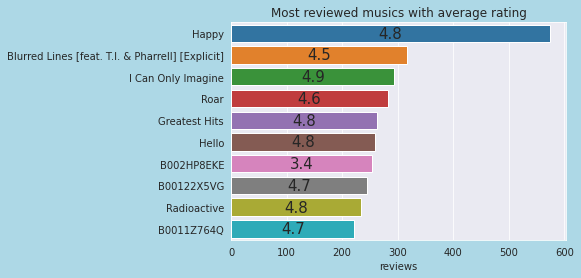

In [ ]:
high_rating = joined_df.groupby('asin', 'title').agg(f.mean('rating').alias('rating'), f.count('rating').alias('reviews'))\
.sort('reviews','rating', ascending = 1 == 2)
tdf = high_rating.limit(10).toPandas()
tdf.title = [t if t is not None else i for t, i in zip(tdf.title, tdf.asin)]
p = sns.barplot('reviews', 'title', data = tdf)
plt.title('Most reviewed musics with average rating')
plt.ylabel('')
for i, s in tdf.iterrows():
    p.text(s['reviews'] / 2, i, round(s['rating'],1), ha = 'center', va = 'center', size = 15)

**Which styles of musics have a lot of reviews and what are the average ratings?**

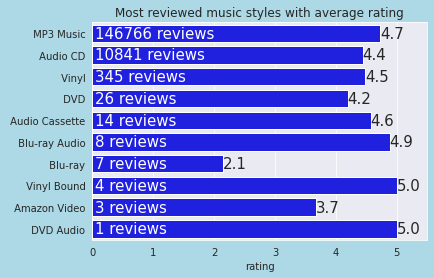

In [ ]:
style = joined_df.dropna(subset = ['style']).groupby('style').agg(f.mean('rating').alias('rating'), f.count('rating').alias('reviews'))\
.sort('reviews', 'rating', ascending = 1 == 2)
tdf = style.limit(10).toPandas()
tdf.rating = tdf.rating.map(lambda x: round(x, 2))
p = sns.barplot('rating', 'style', data = tdf, color = 'b')
plt.title('Most reviewed music styles with average rating')
plt.ylabel('')
plt.xlim(right = 5.5)
for i, s in tdf.iterrows():
    p.text(0.05, i, str(s['reviews']) + ' reviews', ha = 'left', va = 'center', size = 15, color = 'w')
    p.text(s['rating'], i, round(s['rating'],1), ha = 'left', va = 'center', size = 15)

# Preprocessing & Modeling

**Split data into training and testing set**

In [16]:
train, test, val = joined_df.randomSplit([.8, .15, .05])

**Create numeric user and item ids for PySpark ALS model**

In [17]:
union = train.unionAll(test)
item = union.select('asin').distinct().selectExpr('asin','row_number() over(order by asin) as item')
user = union.select('reviewerID').distinct().selectExpr('reviewerID','row_number() over(order by reviewerID) as user')
train = train.join(item, on = 'asin').join(user, on = 'reviewerID')
test = test.join(item, on = 'asin').join(user, on = 'reviewerID')

**Check data types**

In [ ]:
train.printSchema()

root
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- style: string (nullable = true)
 |-- title: string (nullable = true)
 |-- item: integer (nullable = true)
 |-- user: integer (nullable = true)



**Define ALS model**

In [ ]:
als = ALS(coldStartStrategy = 'drop', nonnegative = 1 == 1)
als.setPredictionCol('prediction')

**Perform hyperparameter tuning**

In [ ]:
grid = ParamGridBuilder().addGrid(als.rank, [5, 10, 15]).addGrid(als.maxIter, [18, 19, 20]).addGrid(als.regParam, [.17, .18, .19]).build()
cv = CrossValidator(estimator = als, estimatorParamMaps = grid, evaluator = RegressionEvaluator(labelCol = 'rating'))
model = cv.fit(train)

**Testing data set MAE score**

In [ ]:
RegressionEvaluator(labelCol = 'rating', metricName='mae').evaluate(model.transform(test))

0.2751473090702802

**Class to use for recommendations**

In [ ]:
add = user.selectExpr('max(user) as mx').collect()[0].mx
class recommender:
    def __init__(self, rating_df):
        '''
        The class makes recommendations.
        Initialize the class with a Spark dataframe including columns reviewerID, asin, & overall.
        '''
        users = rating_df.select('reviewerID').distinct().selectExpr('reviewerID','row_number() over(order by reviewerID) as user')
        self.user = users.withColumn('user', users.user + f.lit(add))
        self.user = self.user.unionAll(user)
        self.df = rating_df.selectExpr('reviewerID', 'asin', 'overall as rating').join(item, on = 'asin').join(self.user, on = 'reviewerID')

    def recommend(self, subset = None, n = 5, user = 1 == 1):
        '''
        Recommend n items/users for each users/items.
        subset(list of user/item ids) - Subset of reviewerID/asin to recommend.
        Returns a list if recommending for single user/item, otherwise a spark dataframe would be returned.
        '''
        rec = getattr(model.bestModel, 'recommendForUserSubset' if user else 'recommendForItemSubset')
        user2user_df = self.user if user else item
        user2item_df = item if user else self.user
        user2user = 'user' if user else 'item'
        user2rev = 'reviewerID' if user else 'asin'
        user2asin = 'asin' if user else 'reviewerID'
        user2item = 'item' if user else 'user'
        if subset != None:
            if not type(subset) == list:
                raise ValueError('subset must be a list if specified.')
            count = len(subset)
            exp = ','.join([f'"{x}"' for x in subset])
            df = self.df.where(f'{user2rev} in ({exp})')  
        else:
            df = self.df
            count = df.select(user2user).distinct().count()
        if df.count() == 0: return print('user/item not found')
        rec_df = rec(df, n)
        if count == 1:
            recommendations = [r.recommendations for r in rec_df.collect()][0]
            ids = [getattr(r, user2item) for r in recommendations]
            return [getattr(r, user2asin) for r in user2item_df.collect() if getattr(r, user2item) in ids]
        else:
            def get_suggestions(x):
                id_list = [getattr(r, user2item) for r in x]
                exp = ','.join([str(i) for i in id_list])
                pdf = user2item_df.where(f'{user2item} in ({exp})').toPandas()
                return pdf[user2asin].to_list()
            ans = [(getattr(r, user2user), get_suggestions(r.recommendations)) for r in rec_df.collect()]
            ids_type = types.StructField(user2user, types.IntegerType())
            suggestions_type = types.StructField('recommendations', types.ArrayType(types.StringType()))
            rec_df = spark.createDataFrame(ans, schema = types.StructType([ids_type, suggestions_type])) 
            return rec_df.join(user2user_df, on = user2user).select(user2rev, 'recommendations')

**Recommend users for item(s)**

In [ ]:
tt = recommender(val.withColumnRenamed('rating', 'overall'))
tt.recommend(subset = ["B000TDYS56", "B0012EELIK"], user = 1 == 2).show()

+----------+--------------------+
|      asin|     recommendations|
+----------+--------------------+
|B0012EELIK|[A16FF6XI97ULV6, ...|
|B000TDYS56|[A1L1VZ854S2FB2, ...|
+----------+--------------------+



In [ ]:
tt.recommend(subset = ["B000TDYS56"], user = 1 == 2)

['A1L1VZ854S2FB2',
 'A2IOOH76T0G1MU',
 'A38MP32CYE67B3',
 'A3KEFQBHCUP788',
 'ACT7HS5RPNU5P']

**Recommend items to users**

In [ ]:
tt.recommend(subset = ["A39BN484AZ9NMW", "A3U3XGI6UL76H8"]).show()

+--------------+--------------------+
|    reviewerID|     recommendations|
+--------------+--------------------+
|A39BN484AZ9NMW|[B00136PQ72, B001...|
|A3U3XGI6UL76H8|[B000VWP5PW, B001...|
+--------------+--------------------+

